In [1]:
1*2

2

In [2]:
import importlib
def rl():
    importlib.reload(Di)

In [3]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
import gpytorch

from scipy.stats import pearsonr
from scipy.special import binom as binom
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

import Di

In [5]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())
output_device = 0
n_devices = torch.cuda.device_count()

8
0


In [6]:
geno_file_list = []
for path, currentDirectory, files in os.walk("96ghpptzvf-4/SData2/"):
    for file in files:
        if file.endswith("geno.txt"):
            geno_file_list.append(file)

geno_file_list = list(set(geno_file_list))

env_list = [file.split('_')[0] for file in geno_file_list]

env_list = sorted(env_list)

env = env_list[5]

df = pd.read_csv("96ghpptzvf-4/SData2/"+ env + "_geno.txt", sep='\t', nrows=5, engine='python')

ids = list(df.columns[3:])

env + '_matsui_geno_t.pt'

geno_t = torch.load(env + '_matsui_geno_t.pt')

geno_t = torch.tensor(geno_t, dtype=torch.float)

geno_t = torch.transpose(geno_t, 0, 1)
N, L = geno_t.shape

# geno_t = geno_t[:, :5000]

pheno = pd.read_csv("96ghpptzvf-4/SData6/" + env + "_pheno.txt", sep='\t', engine="python")

pheno = pheno.set_index('geno')

pheno = pheno.loc[ids]

inds_sub = np.where(np.array(pheno.pheno < -0.6) == False)[0]

np.random.seed(100)

sub = np.random.choice(inds_sub, 150000)

sub_t = np.random.choice(list(set(inds_sub).difference(sub)), 5000)

train_x = geno_t[sub]
train_y = torch.tensor(np.array(pheno.pheno[sub]), dtype=torch.float32)

test_x = geno_t[sub_t]
test_y = torch.tensor(np.array(pheno.pheno[sub_t]), dtype=torch.float32)

train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

/scratch/local/42291897/ipykernel_48498/565950420.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  geno_t = torch.tensor(geno_t, dtype=torch.float)


In [22]:
x1 = train_x[:10]
x2 = train_x[10:30]

### Test kernel partitioning

#### Define kernel

In [7]:
from gpytorch import lazy

In [8]:
def d(geno1, geno2):
  """build distance tensor between two sets of genotypes
  geno1, geno2: n x L, m x L torch tensors
  
  """
  geno1_h0 = 1.*(geno1 == 0.)
  geno1_h1 = 1.*(geno1 == 2.)
  geno2_h0 = 1.*(geno2 == 0.)
  geno2_h1 = 1.*(geno2 == 2.)
  S1 = torch.matmul(geno1%2, torch.transpose(geno2%2, 0, 1))
  S2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h0, 0, 1)) 
        + torch.matmul(geno1_h1, torch.transpose(geno2_h1, 0, 1)))
  D2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h1, 0, 1)) 
        + torch.matmul(geno1_h1, torch.transpose(geno2_h0, 0, 1)))
  D1 = L - S1 - S2 - D2

  return torch.stack((S1, S2, D1, D2))


def k(log_lda, log_eta, dvec):
    """
    log_lda, log_eta -- torch tensors
    dvec -- 4 x n x m torch tensor
    """
    lda = torch.exp(log_lda)
    eta = torch.exp(log_eta)
    return (((1 + lda + eta)**(dvec[1] - L/2))
          *((1 - lda + eta)**dvec[3])
          *((1 + eta)**(dvec[0] - L/2)) 
          * (1-eta)**dvec[2])


In [9]:
# prod = lazy.MatmulLazyTensor(train_x[:100], train_x[:100].transpose(0,1))

In [10]:
#   geno1_h0 = 1.*(geno1 == 0.)
#   geno1_h1 = 1.*(geno1 == 2.)
#   geno2_h0 = 1.*(geno2 == 0.)
#   geno2_h1 = 1.*(geno2 == 2.)
#   S1 = torch.matmul(geno1%2, torch.transpose(geno2%2, 0, 1))
#   S2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h0, 0, 1)) 
#         + torch.matmul(geno1_h1, torch.transpose(geno2_h1, 0, 1)))
#   D2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h1, 0, 1)) 
#         + torch.matmul(geno1_h1, torch.transpose(geno2_h0, 0, 1)))
#   D1 = L - S1 - S2 - D2
#   return torch.stack((S1, S2, D1, D2))


In [11]:
# class LinKernel(gpytorch.kernels.Kernel):
#   """
#   Additive kernel
#   no free parameters
#   calculated using the D tensor
#   """

#   is_stationary = True

#   # We will register the parameter when initializing the kernel
#   def __init__(self,
#                 **kwargs):
#       super().__init__(**kwargs)

#   def forward(self, geno1, geno2, diag=False, **params):
#         geno1_h0 = 1.*(geno1 == 0.)
#         geno1_h1 = 1.*(geno1 == 2.)
#         geno2_h0 = 1.*(geno2 == 0.)
#         geno2_h1 = 1.*(geno2 == 2.)
# #         S1 = lazy.MatmulLazyTensor(geno1%2, torch.transpose(geno2%2, 0, 1))
#         S2 = (lazy.MatmulLazyTensor(geno1_h0, torch.transpose(geno2_h0, 0, 1)) 
#             + lazy.MatmulLazyTensor(geno1_h1, torch.transpose(geno2_h1, 0, 1)))
#         D2 = (lazy.MatmulLazyTensor(geno1_h0, torch.transpose(geno2_h1, 0, 1)) 
#             + lazy.MatmulLazyTensor(geno1_h1, torch.transpose(geno2_h0, 0, 1)))
# #         prod = (1 + lda + eta)**(S2.evaluate() - L/2)
#         K = S2 - D2



#         return K.diag() if diag else K


In [12]:
lda = torch.exp(torch.tensor(-8.))
eta = torch.exp(torch.tensor(-12.))

In [13]:
class LinKernel(gpytorch.kernels.Kernel):
    """
    Additive kernel
    no free parameters
    calculated using the D tensor
    """

    is_stationary = True

  # We will register the parameter when initializing the kernel
    def __init__(self,
                **kwargs):
      super().__init__(**kwargs)



    def forward(self, geno1, geno2, diag=False, **params):
#         geno1_h0 = 1.*(geno1 == 0.)
#         geno1_h1 = 1.*(geno1 == 2.)
#         geno2_h0 = 1.*(geno2 == 0.)
#         geno2_h1 = 1.*(geno2 == 2.)
#         S1 = torch.matmul(geno1%2, torch.transpose(geno2%2, 0, 1))
#         S2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h0, 0, 1)) 
#             + torch.matmul(geno1_h1, torch.transpose(geno2_h1, 0, 1)))
#         D2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h1, 0, 1)) 
#             + torch.matmul(geno1_h1, torch.transpose(geno2_h0, 0, 1)))
#         prod = (S1.div(L**2))
#         prod = lda**S1

#         prod = ((1 + lda + eta)**(S2 - L/2))*((1 - lda + eta)**D2)*((1 + eta)**(S1 - L/2))*(1-eta)**(L - S1 - S2 - D2)

        diff = self.covar_dist(geno1, geno2, **params)
        prod =  diff


        return prod.diag() if diag else prod

In [14]:
import gpytorch.kernels.kernel as kernel

In [57]:
import math


from gpytorch.constraints import Positive
from gpytorch.constraints import LessThan

class CosineKernel((gpytorch.kernels.Kernel)):

    is_stationary = True

    def __init__(self, period_length_prior=None, period_length_constraint=None, **kwargs):
        super(CosineKernel, self).__init__(**kwargs)

        self.register_parameter(
            name="raw_period_length", parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        if period_length_constraint is None:
            period_length_constraint = Positive()

        if period_length_prior is not None:
            self.register_prior(
                "period_length_prior",
                period_length_prior,
                lambda m: m.period_length,
                lambda m, v: m._set_period_length(v),
            )

        self.register_constraint("raw_period_length", period_length_constraint)

    @property
    def period_length(self):
        return self.raw_period_length_constraint.transform(self.raw_period_length)

    @period_length.setter
    def period_length(self, value):
        return self._set_period_length(value)

    def _set_period_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_period_length)

        self.initialize(raw_period_length=self.raw_period_length_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        x1_ = x1
        x2_ = x2
        diff = x1_.matmul(x2_.t())
#         diff = self.covar_dist(x1_, x2_, **params)
        res = torch.exp(-.01*diff)
        return res

In [58]:
ker = CosineKernel()

In [59]:
ker(x1, x1).evaluate()

tensor([[0.0000e+00, 2.9989e-38, 1.4129e-37, 1.4848e-33, 2.4663e-32, 0.0000e+00,
         5.4502e-37, 1.4013e-45, 8.1336e-41, 4.2666e-39],
        [2.9989e-38, 0.0000e+00, 5.7872e-37, 1.8550e-34, 1.2588e-31, 4.0638e-44,
         1.5807e-34, 2.7827e-40, 2.4984e-37, 7.0685e-37],
        [1.4129e-37, 5.7872e-37, 0.0000e+00, 9.4221e-36, 2.2374e-33, 1.5204e-42,
         1.6373e-36, 1.4239e-40, 3.3068e-41, 1.1920e-37],
        [1.4848e-33, 1.8550e-34, 9.4221e-36, 0.0000e+00, 1.9004e-24, 5.7892e-41,
         6.9262e-33, 7.1556e-34, 5.0572e-39, 2.8590e-35],
        [2.4663e-32, 1.2588e-31, 2.2374e-33, 1.9004e-24, 2.4803e-43, 7.6177e-35,
         6.8573e-33, 4.0467e-34, 6.8928e-35, 1.2527e-33],
        [0.0000e+00, 4.0638e-44, 1.5204e-42, 5.7892e-41, 7.6177e-35, 0.0000e+00,
         4.0091e-42, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.4502e-37, 1.5807e-34, 1.6373e-36, 6.9262e-33, 6.8573e-33, 4.0091e-42,
         0.0000e+00, 5.9923e-35, 1.5425e-40, 3.2496e-42],
        [1.4013e-45, 2.7827

In [60]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = ker

        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [61]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)

model = ExactGPModel(train_x, train_y, likelihood, n_devices)
# model.covar_module.module.raw_lda = torch.nn.Parameter(torch.tensor(-8.))
# model.covar_module.module.raw_eta = torch.nn.Parameter(torch.tensor(-12.))
model = model.to(output_device)
# model = model.to(output_device).double()
optimizer = torch.optim.AdamW(model.parameters(), .02)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [62]:
checkpoint_size = train_x.shape[0]//2
preconditioner_size = 100

with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
     gpytorch.settings.max_preconditioner_size(preconditioner_size):
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.zero_grad()
    optimizer.step()

RuntimeError: CUDA out of memory. Tried to allocate 83.82 GiB (GPU 0; 79.35 GiB total capacity; 12.23 GiB already allocated; 52.38 GiB free; 25.11 GiB reserved in total by PyTorch)

#### Find checkpoint_size

In [36]:
N = train_x.size(0)

# Find the optimum partition/checkpoint size by decreasing in powers of 2
# Start with no partitioning (size = 0)
settings = [0] + [int(n) for n in np.ceil(N / 2**np.arange(1, np.floor(np.log2(N))))]

In [35]:
# settings = settings[2:]

In [36]:
import gc

def find_best_gpu_setting(train_x,
                          train_y,
                          n_devices,
                          output_device,
                          preconditioner_size
):

    for checkpoint_size in settings:
        print('Number of devices: {} -- Kernel partition size: {}'.format(n_devices, checkpoint_size))
        try:
            # Try a full forward and backward pass with this setting to check memory usage
            

            with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
                 gpytorch.settings.max_preconditioner_size(preconditioner_size):
                output = model(train_x)
                loss = -mll(output, train_y)
                loss.backward()
                optimizer.zero_grad()
                optimizer.step()
    
            

            # when successful, break out of for-loop and jump to finally block
            break
        except RuntimeError as e:
            print('RuntimeError: {}'.format(e))
        except AttributeError as e:
            print('AttributeError: {}'.format(e))
        finally:
            # handle CUDA OOM error
            gc.collect()
            torch.cuda.empty_cache()
    return checkpoint_size

model.train()
likelihood.train()

# Set a large enough preconditioner size to reduce the number of CG iterations run
preconditioner_size = 100
checkpoint_size = find_best_gpu_setting(train_x, train_y,
                                        n_devices=n_devices,
                                        output_device=output_device,
                                        preconditioner_size=preconditioner_size)
print("final checkpoint_size = %s" %checkpoint_size)

Number of devices: 8 -- Kernel partition size: 0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


RuntimeError: CUDA out of memory. Tried to allocate 10.48 GiB (GPU 0; 79.35 GiB total capacity; 62.46 GiB already allocated; 4.32 GiB free; 73.17 GiB reserved in total by PyTorch)
Number of devices: 8 -- Kernel partition size: 75000
final checkpoint_size = 75000


In [40]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 39% |
|  1 |  0% | 21% |
|  2 |  0% | 21% |
|  3 |  0% | 21% |
|  4 |  0% | 21% |
|  5 |  0% | 21% |
|  6 |  0% | 21% |
|  7 |  0% | 21% |


In [52]:
# def test_part(train_x,train_y,n_devices,output_device,preconditioner_size):
#     with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
#          gpytorch.settings.max_preconditioner_size(preconditioner_size):
#         output = model(train_x)
#         loss = -mll(output, train_y)
#     return loss

# checkpoint_size = checkpoint_size
# preconditioner_size = 100

# test_part(train_x, train_y, n_devices=n_devices, output_device=output_device, preconditioner_size=preconditioner_size)

### Train and predict

In [41]:
def train_model(model, 
                likelihood, 
                train_x, 
                train_y, 
                checkpoint_size, 
                preconditioner_size, 
                training_iter=300, 
                lr=.05):
    losses = []
    optimizer = torch.optim.AdamW(model.parameters(), lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    for i in range(training_iter):
        print(i)
        with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
             gpytorch.settings.max_preconditioner_size(preconditioner_size):
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()  
            losses.append(loss.item())
            optimizer.step()        

In [42]:
optimizer = torch.optim.AdamW(model.parameters(), lr=.1)
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer.zero_grad()
# Output from model

In [43]:
# checkpoint_size = train_x.shape[0]//2
checkpoint_size = 0
preconditioner_size = 100

In [56]:
with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
     gpytorch.settings.max_preconditioner_size(preconditioner_size):
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()  
    optimizer.step()

/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


In [33]:
losses = train_model(model, 
                likelihood, 
                train_x, 
                train_y, 
                checkpoint_size, 
                preconditioner_size, 
                training_iter=5, 
                lr=.5)

0


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/juannanzhou/.local/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/kernels/kernel.py", line 398, in __call__
    res = lazify(super(Kernel, self).__call__(x1_, x2_, last_dim_is_batch=last_dim_is_batch, **params))
  File "/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/module.py", line 30, in __call__
    outputs = self.forward(*inputs, **kwargs)
  File "/blue/juannanzhou/matsui_data/Di.py", line 136, in forward
    diff = d(x1, x2)
  File "/blue/juannanzhou/matsui_data/Di.py", line 39, in d
    return torch.stack((S1, S2, D1, D2))
RuntimeError: CUDA out of memory. Tried to allocate 18.63 GiB (GPU 0; 79.35 GiB total capacity; 38.36 GiB already allocated; 16.23 GiB free; 61.25 GiB reserved in total by PyTorch)


In [33]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

likelihood.noise_covar.raw_noise tensor([-2.4149], device='cuda:0')
mean_module.constant tensor([0.5239], device='cuda:0')
covar_module.module.raw_outputscale tensor(-2.3764, device='cuda:0')
covar_module.module.base_kernel.raw_lengthscale tensor([[2.3349]], device='cuda:0')


In [34]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 60% |
|  1 |  0% | 48% |
|  2 |  0% | 48% |
|  3 |  0% | 48% |
|  4 |  0% | 48% |
|  5 |  0% | 48% |
|  6 |  0% | 48% |
|  7 |  0% | 48% |


#### Prediction

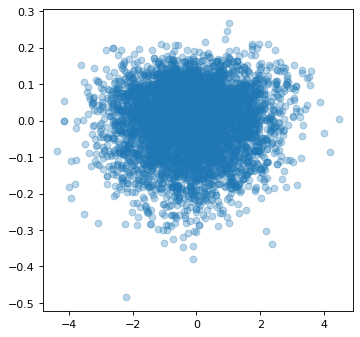

r2 = 0.001976
R2 = -182.358695
mse = 1.601331


In [46]:
preconditioner_size = 100
# checkpoint_size = checkpoint_size=train_x.shape[0]//2

test_x = test_x.cuda()
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.beta_features.checkpoint_kernel(checkpoint_size):
    # Make predictions on a small number of test points to get the test time caches computed
    f_preds = model(test_x)


f_mean = f_preds.mean.cpu().detach().numpy()
y_test = test_y.detach().cpu().numpy()

# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean, y_test)[0]**2)
print('R2 = %f'%r2(y_test, f_mean))
print('mse = %f'%mse(f_mean, y_test))

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from copy import deepcopy
from torch.optim import Optimizer


def is_legal(v):
    """
    Checks that tensor is not NaN or Inf.

    Inputs:
        v (tensor): tensor to be checked

    """
    legal = not torch.isnan(v).any() and not torch.isinf(v)

    return legal


def polyinterp(points, x_min_bound=None, x_max_bound=None, plot=False):
    """
    Gives the minimizer and minimum of the interpolating polynomial over given points
    based on function and derivative information. Defaults to bisection if no critical
    points are valid.

    Based on polyinterp.m Matlab function in minFunc by Mark Schmidt with some slight
    modifications.

    Implemented by: Hao-Jun Michael Shi and Dheevatsa Mudigere
    Last edited 12/6/18.

    Inputs:
        points (nparray): two-dimensional array with each point of form [x f g]
        x_min_bound (float): minimum value that brackets minimum (default: minimum of points)
        x_max_bound (float): maximum value that brackets minimum (default: maximum of points)
        plot (bool): plot interpolating polynomial

    Outputs:
        x_sol (float): minimizer of interpolating polynomial
        F_min (float): minimum of interpolating polynomial

    Note:
      . Set f or g to np.nan if they are unknown

    """
    no_points = points.shape[0]
    order = np.sum(1 - np.isnan(points[:, 1:3]).astype('int')) - 1

    x_min = np.min(points[:, 0])
    x_max = np.max(points[:, 0])

    # compute bounds of interpolation area
    if x_min_bound is None:
        x_min_bound = x_min
    if x_max_bound is None:
        x_max_bound = x_max

    # explicit formula for quadratic interpolation
    if no_points == 2 and order == 2 and plot is False:
        # Solution to quadratic interpolation is given by:
        # a = -(f1 - f2 - g1(x1 - x2))/(x1 - x2)^2
        # x_min = x1 - g1/(2a)
        # if x1 = 0, then is given by:
        # x_min = - (g1*x2^2)/(2(f2 - f1 - g1*x2))

        if points[0, 0] == 0:
            x_sol = -points[0, 2] * points[1, 0] ** 2 / (2 * (points[1, 1] - points[0, 1] - points[0, 2] * points[1, 0]))
        else:
            a = -(points[0, 1] - points[1, 1] - points[0, 2] * (points[0, 0] - points[1, 0])) / (points[0, 0] - points[1, 0]) ** 2
            x_sol = points[0, 0] - points[0, 2]/(2*a)

        x_sol = np.minimum(np.maximum(x_min_bound, x_sol), x_max_bound)

    # explicit formula for cubic interpolation
    elif no_points == 2 and order == 3 and plot is False:
        # Solution to cubic interpolation is given by:
        # d1 = g1 + g2 - 3((f1 - f2)/(x1 - x2))
        # d2 = sqrt(d1^2 - g1*g2)
        # x_min = x2 - (x2 - x1)*((g2 + d2 - d1)/(g2 - g1 + 2*d2))
        d1 = points[0, 2] + points[1, 2] - 3 * ((points[0, 1] - points[1, 1]) / (points[0, 0] - points[1, 0]))
        d2 = np.sqrt(d1 ** 2 - points[0, 2] * points[1, 2])
        if np.isreal(d2):
            x_sol = points[1, 0] - (points[1, 0] - points[0, 0]) * ((points[1, 2] + d2 - d1) / (points[1, 2] - points[0, 2] + 2 * d2))
            x_sol = np.minimum(np.maximum(x_min_bound, x_sol), x_max_bound)
        else:
            x_sol = (x_max_bound + x_min_bound)/2

    # solve linear system
    else:
        # define linear constraints
        A = np.zeros((0, order + 1))
        b = np.zeros((0, 1))

        # add linear constraints on function values
        for i in range(no_points):
            if not np.isnan(points[i, 1]):
                constraint = np.zeros((1, order + 1))
                for j in range(order, -1, -1):
                    constraint[0, order - j] = points[i, 0] ** j
                A = np.append(A, constraint, 0)
                b = np.append(b, points[i, 1])

        # add linear constraints on gradient values
        for i in range(no_points):
            if not np.isnan(points[i, 2]):
                constraint = np.zeros((1, order + 1))
                for j in range(order):
                    constraint[0, j] = (order - j) * points[i, 0] ** (order - j - 1)
                A = np.append(A, constraint, 0)
                b = np.append(b, points[i, 2])

        # check if system is solvable
        if A.shape[0] != A.shape[1] or np.linalg.matrix_rank(A) != A.shape[0]:
            x_sol = (x_min_bound + x_max_bound)/2
            f_min = np.Inf
        else:
            # solve linear system for interpolating polynomial
            coeff = np.linalg.solve(A, b)

            # compute critical points
            dcoeff = np.zeros(order)
            for i in range(len(coeff) - 1):
                dcoeff[i] = coeff[i] * (order - i)

            crit_pts = np.array([x_min_bound, x_max_bound])
            crit_pts = np.append(crit_pts, points[:, 0])

            if not np.isinf(dcoeff).any():
                roots = np.roots(dcoeff)
                crit_pts = np.append(crit_pts, roots)

            # test critical points
            f_min = np.Inf
            x_sol = (x_min_bound + x_max_bound) / 2 # defaults to bisection
            for crit_pt in crit_pts:
                if np.isreal(crit_pt) and crit_pt >= x_min_bound and crit_pt <= x_max_bound:
                    F_cp = np.polyval(coeff, crit_pt)
                    if np.isreal(F_cp) and F_cp < f_min:
                        x_sol = np.real(crit_pt)
                        f_min = np.real(F_cp)

            if(plot):
                plt.figure()
                x = np.arange(x_min_bound, x_max_bound, (x_max_bound - x_min_bound)/10000)
                f = np.polyval(coeff, x)
                plt.plot(x, f)
                plt.plot(x_sol, f_min, 'x')

    return x_sol


class LBFGS(Optimizer):
    """
    Implements the L-BFGS algorithm. Compatible with multi-batch and full-overlap
    L-BFGS implementations and (stochastic) Powell damping. Partly based on the 
    original L-BFGS implementation in PyTorch, Mark Schmidt's minFunc MATLAB code, 
    and Michael Overton's weak Wolfe line search MATLAB code.

    Implemented by: Hao-Jun Michael Shi and Dheevatsa Mudigere
    Last edited 10/20/20.

    Warnings:
      . Does not support per-parameter options and parameter groups.
      . All parameters have to be on a single device.

    Inputs:
        lr (float): steplength or learning rate (default: 1)
        history_size (int): update history size (default: 10)
        line_search (str): designates line search to use (default: 'Wolfe')
            Options:
                'None': uses steplength designated in algorithm
                'Armijo': uses Armijo backtracking line search
                'Wolfe': uses Armijo-Wolfe bracketing line search
        dtype: data type (default: torch.float)
        debug (bool): debugging mode

    References:
    [1] Berahas, Albert S., Jorge Nocedal, and Martin Takác. "A Multi-Batch L-BFGS 
        Method for Machine Learning." Advances in Neural Information Processing 
        Systems. 2016.
    [2] Bollapragada, Raghu, et al. "A Progressive Batching L-BFGS Method for Machine 
        Learning." International Conference on Machine Learning. 2018.
    [3] Lewis, Adrian S., and Michael L. Overton. "Nonsmooth Optimization via Quasi-Newton
        Methods." Mathematical Programming 141.1-2 (2013): 135-163.
    [4] Liu, Dong C., and Jorge Nocedal. "On the Limited Memory BFGS Method for 
        Large Scale Optimization." Mathematical Programming 45.1-3 (1989): 503-528.
    [5] Nocedal, Jorge. "Updating Quasi-Newton Matrices With Limited Storage." 
        Mathematics of Computation 35.151 (1980): 773-782.
    [6] Nocedal, Jorge, and Stephen J. Wright. "Numerical Optimization." Springer New York,
        2006.
    [7] Schmidt, Mark. "minFunc: Unconstrained Differentiable Multivariate Optimization 
        in Matlab." Software available at http://www.cs.ubc.ca/~schmidtm/Software/minFunc.html 
        (2005).
    [8] Schraudolph, Nicol N., Jin Yu, and Simon Günter. "A Stochastic Quasi-Newton 
        Method for Online Convex Optimization." Artificial Intelligence and Statistics. 
        2007.
    [9] Wang, Xiao, et al. "Stochastic Quasi-Newton Methods for Nonconvex Stochastic 
        Optimization." SIAM Journal on Optimization 27.2 (2017): 927-956.

    """

    def __init__(self, params, lr=1., history_size=10, line_search='Wolfe',
                 dtype=torch.float, debug=False):

        # ensure inputs are valid
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0 <= history_size:
            raise ValueError("Invalid history size: {}".format(history_size))
        if line_search not in ['Armijo', 'Wolfe', 'None']:
            raise ValueError("Invalid line search: {}".format(line_search))

        defaults = dict(lr=lr, history_size=history_size, line_search=line_search, dtype=dtype, debug=debug)
        super(LBFGS, self).__init__(params, defaults)

        if len(self.param_groups) != 1:
            raise ValueError("L-BFGS doesn't support per-parameter options "
                             "(parameter groups)")

        self._params = self.param_groups[0]['params']
        self._numel_cache = None

        state = self.state['global_state']
        state.setdefault('n_iter', 0)
        state.setdefault('curv_skips', 0)
        state.setdefault('fail_skips', 0)
        state.setdefault('H_diag',1)
        state.setdefault('fail', True)

        state['old_dirs'] = []
        state['old_stps'] = []

    def _numel(self):
        if self._numel_cache is None:
            self._numel_cache = reduce(lambda total, p: total + p.numel(), self._params, 0)
        return self._numel_cache

    def _gather_flat_grad(self):
        views = []
        for p in self._params:
            if p.grad is None:
                view = p.data.new(p.data.numel()).zero_()
            elif p.grad.data.is_sparse:
                view = p.grad.data.to_dense().view(-1)
            else:
                view = p.grad.data.view(-1)
            views.append(view)
        return torch.cat(views, 0)

    def _add_update(self, step_size, update):
        offset = 0
        for p in self._params:
            numel = p.numel()
            # view as to avoid deprecated pointwise semantics
            p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))
            offset += numel
        assert offset == self._numel()

    def _copy_params(self):
        current_params = []
        for param in self._params:
            current_params.append(deepcopy(param.data))
        return current_params

    def _load_params(self, current_params):
        i = 0
        for param in self._params:
            param.data[:] = current_params[i]
            i += 1

    def line_search(self, line_search):
        """
        Switches line search option.
        
        Inputs:
            line_search (str): designates line search to use
                Options:
                    'None': uses steplength designated in algorithm
                    'Armijo': uses Armijo backtracking line search
                    'Wolfe': uses Armijo-Wolfe bracketing line search
        
        """
        
        group = self.param_groups[0]
        group['line_search'] = line_search
        
        return

    def two_loop_recursion(self, vec):
        """
        Performs two-loop recursion on given vector to obtain Hv.

        Inputs:
            vec (tensor): 1-D tensor to apply two-loop recursion to

        Output:
            r (tensor): matrix-vector product Hv

        """

        group = self.param_groups[0]
        history_size = group['history_size']

        state = self.state['global_state']
        old_dirs = state.get('old_dirs')    # change in gradients
        old_stps = state.get('old_stps')    # change in iterates
        H_diag = state.get('H_diag')

        # compute the product of the inverse Hessian approximation and the gradient
        num_old = len(old_dirs)

        if 'rho' not in state:
            state['rho'] = [None] * history_size
            state['alpha'] = [None] * history_size
        rho = state['rho']
        alpha = state['alpha']

        for i in range(num_old):
            rho[i] = 1. / old_stps[i].dot(old_dirs[i])

        q = vec
        for i in range(num_old - 1, -1, -1):
            alpha[i] = old_dirs[i].dot(q) * rho[i]
            q.add_(-alpha[i], old_stps[i])

        # multiply by initial Hessian 
        # r/d is the final direction
        r = torch.mul(q, H_diag)
        for i in range(num_old):
            beta = old_stps[i].dot(r) * rho[i]
            r.add_(alpha[i] - beta, old_dirs[i])

        return r

    def curvature_update(self, flat_grad, eps=1e-2, damping=False):
        """
        Performs curvature update.

        Inputs:
            flat_grad (tensor): 1-D tensor of flattened gradient for computing 
                gradient difference with previously stored gradient
            eps (float): constant for curvature pair rejection or damping (default: 1e-2)
            damping (bool): flag for using Powell damping (default: False)
        """

        assert len(self.param_groups) == 1

        # load parameters
        if(eps <= 0):
            raise(ValueError('Invalid eps; must be positive.'))

        group = self.param_groups[0]
        history_size = group['history_size']
        debug = group['debug']

        # variables cached in state (for tracing)
        state = self.state['global_state']
        fail = state.get('fail')
        
        # check if line search failed
        if not fail:
            
            d = state.get('d')
            t = state.get('t')
            old_dirs = state.get('old_dirs')
            old_stps = state.get('old_stps')
            H_diag = state.get('H_diag')
            prev_flat_grad = state.get('prev_flat_grad')
            Bs = state.get('Bs')
    
            # compute y's
            y = flat_grad.sub(prev_flat_grad)
            s = d.mul(t)
            sBs = s.dot(Bs)
            ys = y.dot(s)  # y*s

            # update L-BFGS matrix
            if ys > eps * sBs or damping == True:
    
                # perform Powell damping
                if damping == True and ys < eps*sBs:
                    if debug:
                        print('Applying Powell damping...')
                    theta = ((1 - eps) * sBs)/(sBs - ys)
                    y = theta * y + (1 - theta) * Bs
    
                # updating memory
                if len(old_dirs) == history_size:
                    # shift history by one (limited-memory)
                    old_dirs.pop(0)
                    old_stps.pop(0)
    
                # store new direction/step
                old_dirs.append(s)
                old_stps.append(y)
    
                # update scale of initial Hessian approximation
                H_diag = ys / y.dot(y)  # (y*y)
                
                state['old_dirs'] = old_dirs
                state['old_stps'] = old_stps
                state['H_diag'] = H_diag

            else:
                # save skip
                state['curv_skips'] += 1
                if debug:
                    print('Curvature pair skipped due to failed criterion')

        else:
            # save skip
            state['fail_skips'] += 1
            if debug:
                print('Line search failed; curvature pair update skipped')

        return

    def _step(self, p_k, g_Ok, g_Sk=None, options=None):
        """
        Performs a single optimization step.

        Inputs:
            p_k (tensor): 1-D tensor specifying search direction
            g_Ok (tensor): 1-D tensor of flattened gradient over overlap O_k used
                            for gradient differencing in curvature pair update
            g_Sk (tensor): 1-D tensor of flattened gradient over full sample S_k
                            used for curvature pair damping or rejection criterion,
                            if None, will use g_Ok (default: None)
            options (dict): contains options for performing line search (default: None)

        Options for Armijo backtracking line search:
            'closure' (callable): reevaluates model and returns function value
            'current_loss' (tensor): objective value at current iterate (default: F(x_k))
            'gtd' (tensor): inner product g_Ok'd in line search (default: g_Ok'd)
            'eta' (tensor): factor for decreasing steplength > 0 (default: 2)
            'c1' (tensor): sufficient decrease constant in (0, 1) (default: 1e-4)
            'max_ls' (int): maximum number of line search steps permitted (default: 10)
            'interpolate' (bool): flag for using interpolation (default: True)
            'inplace' (bool): flag for inplace operations (default: True)
            'ls_debug' (bool): debugging mode for line search

        Options for Wolfe line search:
            'closure' (callable): reevaluates model and returns function value
            'current_loss' (tensor): objective value at current iterate (default: F(x_k))
            'gtd' (tensor): inner product g_Ok'd in line search (default: g_Ok'd)
            'eta' (float): factor for extrapolation (default: 2)
            'c1' (float): sufficient decrease constant in (0, 1) (default: 1e-4)
            'c2' (float): curvature condition constant in (0, 1) (default: 0.9)
            'max_ls' (int): maximum number of line search steps permitted (default: 10)
            'interpolate' (bool): flag for using interpolation (default: True)
            'inplace' (bool): flag for inplace operations (default: True)
            'ls_debug' (bool): debugging mode for line search

        Outputs (depends on line search):
          . No line search:
                t (float): steplength
          . Armijo backtracking line search:
                F_new (tensor): loss function at new iterate
                t (tensor): final steplength
                ls_step (int): number of backtracks
                closure_eval (int): number of closure evaluations
                desc_dir (bool): descent direction flag
                    True: p_k is descent direction with respect to the line search
                    function
                    False: p_k is not a descent direction with respect to the line
                    search function
                fail (bool): failure flag
                    True: line search reached maximum number of iterations, failed
                    False: line search succeeded
          . Wolfe line search:
                F_new (tensor): loss function at new iterate
                g_new (tensor): gradient at new iterate
                t (float): final steplength
                ls_step (int): number of backtracks
                closure_eval (int): number of closure evaluations
                grad_eval (int): number of gradient evaluations
                desc_dir (bool): descent direction flag
                    True: p_k is descent direction with respect to the line search
                    function
                    False: p_k is not a descent direction with respect to the line
                    search function
                fail (bool): failure flag
                    True: line search reached maximum number of iterations, failed
                    False: line search succeeded

        Notes:
          . If encountering line search failure in the deterministic setting, one
            should try increasing the maximum number of line search steps max_ls.

        """

        if options is None:
            options = {}
        assert len(self.param_groups) == 1

        # load parameter options
        group = self.param_groups[0]
        lr = group['lr']
        line_search = group['line_search']
        dtype = group['dtype']
        debug = group['debug']

        # variables cached in state (for tracing)
        state = self.state['global_state']
        d = state.get('d')
        t = state.get('t')
        prev_flat_grad = state.get('prev_flat_grad')
        Bs = state.get('Bs')

        # keep track of nb of iterations
        state['n_iter'] += 1

        # set search direction
        d = p_k

        # modify previous gradient
        if prev_flat_grad is None:
            prev_flat_grad = g_Ok.clone()
        else:
            prev_flat_grad.copy_(g_Ok)

        # set initial step size
        t = lr

        # closure evaluation counter
        closure_eval = 0

        if g_Sk is None:
            g_Sk = g_Ok.clone()

        # perform Armijo backtracking line search
        if line_search == 'Armijo':

            # load options
            if options:
                if 'closure' not in options.keys():
                    raise(ValueError('closure option not specified.'))
                else:
                    closure = options['closure']

                if 'gtd' not in options.keys():
                    gtd = g_Sk.dot(d)
                else:
                    gtd = options['gtd']

                if 'current_loss' not in options.keys():
                    F_k = closure()
                    closure_eval += 1
                else:
                    F_k = options['current_loss']

                if 'eta' not in options.keys():
                    eta = 2
                elif options['eta'] <= 0:
                    raise(ValueError('Invalid eta; must be positive.'))
                else:
                    eta = options['eta']

                if 'c1' not in options.keys():
                    c1 = 1e-4
                elif options['c1'] >= 1 or options['c1'] <= 0:
                    raise(ValueError('Invalid c1; must be strictly between 0 and 1.'))
                else:
                    c1 = options['c1']

                if 'max_ls' not in options.keys():
                    max_ls = 10
                elif options['max_ls'] <= 0:
                    raise(ValueError('Invalid max_ls; must be positive.'))
                else:
                    max_ls = options['max_ls']

                if 'interpolate' not in options.keys():
                    interpolate = True
                else:
                    interpolate = options['interpolate']

                if 'inplace' not in options.keys():
                    inplace = True
                else:
                    inplace = options['inplace']
                    
                if 'ls_debug' not in options.keys():
                    ls_debug = False
                else:
                    ls_debug = options['ls_debug']

            else:
                raise(ValueError('Options are not specified; need closure evaluating function.'))

            # initialize values
            if interpolate:
                if torch.cuda.is_available():
                    F_prev = torch.tensor(np.nan, dtype=dtype).cuda()
                else:
                    F_prev = torch.tensor(np.nan, dtype=dtype)

            ls_step = 0
            t_prev = 0 # old steplength
            fail = False # failure flag

            # begin print for debug mode
            if ls_debug:
                print('==================================== Begin Armijo line search ===================================')
                print('F(x): %.8e  g*d: %.8e' % (F_k, gtd))

            # check if search direction is descent direction
            if gtd >= 0:
                desc_dir = False
                if debug:
                    print('Not a descent direction!')
            else:
                desc_dir = True

            # store values if not in-place
            if not inplace:
                current_params = self._copy_params()

            # update and evaluate at new point
            self._add_update(t, d)
            F_new = closure()
            closure_eval += 1

            # print info if debugging
            if ls_debug:
                print('LS Step: %d  t: %.8e  F(x+td): %.8e  F-c1*t*g*d: %.8e  F(x): %.8e'
                      % (ls_step, t, F_new, F_k + c1 * t * gtd, F_k))

            # check Armijo condition
            while F_new > F_k + c1*t*gtd or not is_legal(F_new):

                # check if maximum number of iterations reached
                if ls_step >= max_ls:
                    if inplace:
                        self._add_update(-t, d)
                    else:
                        self._load_params(current_params)

                    t = 0
                    F_new = closure()
                    closure_eval += 1
                    fail = True
                    break

                else:
                    # store current steplength
                    t_new = t

                    # compute new steplength

                    # if first step or not interpolating, then multiply by factor
                    if ls_step == 0 or not interpolate or not is_legal(F_new):
                        t = t/eta

                    # if second step, use function value at new point along with 
                    # gradient and function at current iterate
                    elif ls_step == 1 or not is_legal(F_prev):
                        t = polyinterp(np.array([[0, F_k.item(), gtd.item()], [t_new, F_new.item(), np.nan]]))

                    # otherwise, use function values at new point, previous point,
                    # and gradient and function at current iterate
                    else:
                        t = polyinterp(np.array([[0, F_k.item(), gtd.item()], [t_new, F_new.item(), np.nan], 
                                                [t_prev, F_prev.item(), np.nan]]))

                    # if values are too extreme, adjust t
                    if interpolate:
                        if t < 1e-3 * t_new:
                            t = 1e-3 * t_new
                        elif t > 0.6 * t_new:
                            t = 0.6 * t_new

                        # store old point
                        F_prev = F_new
                        t_prev = t_new

                    # update iterate and reevaluate
                    if inplace:
                        self._add_update(t - t_new, d)
                    else:
                        self._load_params(current_params)
                        self._add_update(t, d)

                    F_new = closure()
                    closure_eval += 1
                    ls_step += 1 # iterate
                    
                    # print info if debugging
                    if ls_debug:
                        print('LS Step: %d  t: %.8e  F(x+td):   %.8e  F-c1*t*g*d: %.8e  F(x): %.8e'
                              % (ls_step, t, F_new, F_k + c1 * t * gtd, F_k))

            # store Bs
            if Bs is None:
                Bs = (g_Sk.mul(-t)).clone()
            else:
                Bs.copy_(g_Sk.mul(-t))
                
            # print final steplength
            if ls_debug:
                print('Final Steplength:', t)
                print('===================================== End Armijo line search ====================================')

            state['d'] = d
            state['prev_flat_grad'] = prev_flat_grad
            state['t'] = t
            state['Bs'] = Bs
            state['fail'] = fail

            return F_new, t, ls_step, closure_eval, desc_dir, fail

        # perform weak Wolfe line search
        elif line_search == 'Wolfe':

            # load options
            if options:
                if 'closure' not in options.keys():
                    raise(ValueError('closure option not specified.'))
                else:
                    closure = options['closure']

                if 'current_loss' not in options.keys():
                    F_k = closure()
                    closure_eval += 1
                else:
                    F_k = options['current_loss']

                if 'gtd' not in options.keys():
                    gtd = g_Sk.dot(d)
                else:
                    gtd = options['gtd']

                if 'eta' not in options.keys():
                    eta = 2
                elif options['eta'] <= 1:
                    raise(ValueError('Invalid eta; must be greater than 1.'))
                else:
                    eta = options['eta']

                if 'c1' not in options.keys():
                    c1 = 1e-4
                elif options['c1'] >= 1 or options['c1'] <= 0:
                    raise(ValueError('Invalid c1; must be strictly between 0 and 1.'))
                else:
                    c1 = options['c1']

                if 'c2' not in options.keys():
                    c2 = 0.9
                elif options['c2'] >= 1 or options['c2'] <= 0:
                    raise(ValueError('Invalid c2; must be strictly between 0 and 1.'))
                elif options['c2'] <= c1:
                    raise(ValueError('Invalid c2; must be strictly larger than c1.'))
                else:
                    c2 = options['c2']

                if 'max_ls' not in options.keys():
                    max_ls = 10
                elif options['max_ls'] <= 0:
                    raise(ValueError('Invalid max_ls; must be positive.'))
                else:
                    max_ls = options['max_ls']

                if 'interpolate' not in options.keys():
                    interpolate = True
                else:
                    interpolate = options['interpolate']

                if 'inplace' not in options.keys():
                    inplace = True
                else:
                    inplace = options['inplace']
                    
                if 'ls_debug' not in options.keys():
                    ls_debug = False
                else:
                    ls_debug = options['ls_debug']

            else:
                raise(ValueError('Options are not specified; need closure evaluating function.'))

            # initialize counters
            ls_step = 0
            grad_eval = 0 # tracks gradient evaluations
            t_prev = 0 # old steplength

            # initialize bracketing variables and flag
            alpha = 0
            beta = float('Inf')
            fail = False

            # initialize values for line search
            if(interpolate):
                F_a = F_k
                g_a = gtd

                if(torch.cuda.is_available()):
                    F_b = torch.tensor(np.nan, dtype=dtype).cuda()
                    g_b = torch.tensor(np.nan, dtype=dtype).cuda()
                else:
                    F_b = torch.tensor(np.nan, dtype=dtype)
                    g_b = torch.tensor(np.nan, dtype=dtype)

            # begin print for debug mode
            if ls_debug:
                print('==================================== Begin Wolfe line search ====================================')
                print('F(x): %.8e  g*d: %.8e' % (F_k, gtd))

            # check if search direction is descent direction
            if gtd >= 0:
                desc_dir = False
                if debug:
                    print('Not a descent direction!')
            else:
                desc_dir = True

            # store values if not in-place
            if not inplace:
                current_params = self._copy_params()

            # update and evaluate at new point
            self._add_update(t, d)
            F_new = closure()
            closure_eval += 1

            # main loop
            while True:

                # check if maximum number of line search steps have been reached
                if ls_step >= max_ls:
                    if inplace:
                        self._add_update(-t, d)
                    else:
                        self._load_params(current_params)

                    t = 0
                    F_new = closure()
                    F_new.backward()
                    g_new = self._gather_flat_grad()
                    closure_eval += 1
                    grad_eval += 1
                    fail = True
                    break

                # print info if debugging
                if ls_debug:
                    print('LS Step: %d  t: %.8e  alpha: %.8e  beta: %.8e' 
                          % (ls_step, t, alpha, beta))
                    print('Armijo:  F(x+td): %.8e  F-c1*t*g*d: %.8e  F(x): %.8e'
                          % (F_new, F_k + c1 * t * gtd, F_k))

                # check Armijo condition
                if F_new > F_k + c1 * t * gtd:

                    # set upper bound
                    beta = t
                    t_prev = t

                    # update interpolation quantities
                    if interpolate:
                        F_b = F_new
                        if torch.cuda.is_available():
                            g_b = torch.tensor(np.nan, dtype=dtype).cuda()
                        else:
                            g_b = torch.tensor(np.nan, dtype=dtype)

                else:

                    # compute gradient
                    F_new.backward()
                    g_new = self._gather_flat_grad()
                    grad_eval += 1
                    gtd_new = g_new.dot(d)
                    
                    # print info if debugging
                    if ls_debug:
                        print('Wolfe: g(x+td)*d: %.8e  c2*g*d: %.8e  gtd: %.8e'
                              % (gtd_new, c2 * gtd, gtd))

                    # check curvature condition
                    if gtd_new < c2 * gtd:

                        # set lower bound
                        alpha = t
                        t_prev = t

                        # update interpolation quantities
                        if interpolate:
                            F_a = F_new
                            g_a = gtd_new

                    else:
                        break

                # compute new steplength

                # if first step or not interpolating, then bisect or multiply by factor
                if not interpolate or not is_legal(F_b):
                    if beta == float('Inf'):
                        t = eta*t
                    else:
                        t = (alpha + beta)/2.0

                # otherwise interpolate between a and b
                else:
                    t = polyinterp(np.array([[alpha, F_a.item(), g_a.item()], [beta, F_b.item(), g_b.item()]]))

                    # if values are too extreme, adjust t
                    if beta == float('Inf'):
                        if t > 2 * eta * t_prev:
                            t = 2 * eta * t_prev
                        elif t < eta * t_prev:
                            t = eta * t_prev
                    else:
                        if t < alpha + 0.2 * (beta - alpha):
                            t = alpha + 0.2 * (beta - alpha)
                        elif t > (beta - alpha) / 2.0:
                            t = (beta - alpha) / 2.0

                    # if we obtain nonsensical value from interpolation
                    if t <= 0:
                        t = (beta - alpha) / 2.0

                # update parameters
                if inplace:
                    self._add_update(t - t_prev, d)
                else:
                    self._load_params(current_params)
                    self._add_update(t, d)

                # evaluate closure
                F_new = closure()
                closure_eval += 1
                ls_step += 1

            # store Bs
            if Bs is None:
                Bs = (g_Sk.mul(-t)).clone()
            else:
                Bs.copy_(g_Sk.mul(-t))
                
            # print final steplength
            if ls_debug:
                print('Final Steplength:', t)
                print('===================================== End Wolfe line search =====================================')

            state['d'] = d
            state['prev_flat_grad'] = prev_flat_grad
            state['t'] = t
            state['Bs'] = Bs
            state['fail'] = fail

            return F_new, g_new, t, ls_step, closure_eval, grad_eval, desc_dir, fail

        else:

            # perform update
            self._add_update(t, d)

            # store Bs
            if Bs is None:
                Bs = (g_Sk.mul(-t)).clone()
            else:
                Bs.copy_(g_Sk.mul(-t))

            state['d'] = d
            state['prev_flat_grad'] = prev_flat_grad
            state['t'] = t
            state['Bs'] = Bs
            state['fail'] = False

            return t
        
    def step(self, p_k, g_Ok, g_Sk=None, options={}):
        return self._step(p_k, g_Ok, g_Sk, options)


class FullBatchLBFGS(LBFGS):
    """
    Implements full-batch or deterministic L-BFGS algorithm. Compatible with
    Powell damping. Can be used when evaluating a deterministic function and
    gradient. Wraps the LBFGS optimizer. Performs the two-loop recursion,
    updating, and curvature updating in a single step.

    Implemented by: Hao-Jun Michael Shi and Dheevatsa Mudigere
    Last edited 11/15/18.

    Warnings:
      . Does not support per-parameter options and parameter groups.
      . All parameters have to be on a single device.

    Inputs:
        lr (float): steplength or learning rate (default: 1)
        history_size (int): update history size (default: 10)
        line_search (str): designates line search to use (default: 'Wolfe')
            Options:
                'None': uses steplength designated in algorithm
                'Armijo': uses Armijo backtracking line search
                'Wolfe': uses Armijo-Wolfe bracketing line search
        dtype: data type (default: torch.float)
        debug (bool): debugging mode

    """

    def __init__(self, params, lr=1, history_size=10, line_search='Wolfe', 
                 dtype=torch.float, debug=False):
        super(FullBatchLBFGS, self).__init__(params, lr, history_size, line_search, 
             dtype, debug)

    def step(self, options=None):
        """
        Performs a single optimization step.

        Inputs:
            options (dict): contains options for performing line search (default: None)
            
        General Options:
            'eps' (float): constant for curvature pair rejection or damping (default: 1e-2)
            'damping' (bool): flag for using Powell damping (default: False)

        Options for Armijo backtracking line search:
            'closure' (callable): reevaluates model and returns function value
            'current_loss' (tensor): objective value at current iterate (default: F(x_k))
            'gtd' (tensor): inner product g_Ok'd in line search (default: g_Ok'd)
            'eta' (tensor): factor for decreasing steplength > 0 (default: 2)
            'c1' (tensor): sufficient decrease constant in (0, 1) (default: 1e-4)
            'max_ls' (int): maximum number of line search steps permitted (default: 10)
            'interpolate' (bool): flag for using interpolation (default: True)
            'inplace' (bool): flag for inplace operations (default: True)
            'ls_debug' (bool): debugging mode for line search

        Options for Wolfe line search:
            'closure' (callable): reevaluates model and returns function value
            'current_loss' (tensor): objective value at current iterate (default: F(x_k))
            'gtd' (tensor): inner product g_Ok'd in line search (default: g_Ok'd)
            'eta' (float): factor for extrapolation (default: 2)
            'c1' (float): sufficient decrease constant in (0, 1) (default: 1e-4)
            'c2' (float): curvature condition constant in (0, 1) (default: 0.9)
            'max_ls' (int): maximum number of line search steps permitted (default: 10)
            'interpolate' (bool): flag for using interpolation (default: True)
            'inplace' (bool): flag for inplace operations (default: True)
            'ls_debug' (bool): debugging mode for line search

        Outputs (depends on line search):
          . No line search:
                t (float): steplength
          . Armijo backtracking line search:
                F_new (tensor): loss function at new iterate
                t (tensor): final steplength
                ls_step (int): number of backtracks
                closure_eval (int): number of closure evaluations
                desc_dir (bool): descent direction flag
                    True: p_k is descent direction with respect to the line search
                    function
                    False: p_k is not a descent direction with respect to the line
                    search function
                fail (bool): failure flag
                    True: line search reached maximum number of iterations, failed
                    False: line search succeeded
          . Wolfe line search:
                F_new (tensor): loss function at new iterate
                g_new (tensor): gradient at new iterate
                t (float): final steplength
                ls_step (int): number of backtracks
                closure_eval (int): number of closure evaluations
                grad_eval (int): number of gradient evaluations
                desc_dir (bool): descent direction flag
                    True: p_k is descent direction with respect to the line search
                    function
                    False: p_k is not a descent direction with respect to the line
                    search function
                fail (bool): failure flag
                    True: line search reached maximum number of iterations, failed
                    False: line search succeeded

        Notes:
          . If encountering line search failure in the deterministic setting, one
            should try increasing the maximum number of line search steps max_ls.

        """
        
        # load options for damping and eps
        if 'damping' not in options.keys():
            damping = False
        else:
            damping = options['damping']
            
        if 'eps' not in options.keys():
            eps = 1e-2
        else:
            eps = options['eps']
        
        # gather gradient
        grad = self._gather_flat_grad()
        
        # update curvature if after 1st iteration
        state = self.state['global_state']
        if state['n_iter'] > 0:
            self.curvature_update(grad, eps, damping)

        # compute search direction
        p = self.two_loop_recursion(-grad)

        # take step
        return self._step(p, grad, options=options)
